# Discretizers

This package supports discretization methods and mapping functions.

## Installation

In [ ]:
Pkg.add("Discretizers")

Once the installation is complete you can use it anywhere by running

In [1]:
using Discretizers

## Discretization

### Categorical Labels

You can construct an object for mapping labels to integer indeces

In [2]:
data = [:cat, :dog, :dog, :cat, :cat, :elephant]
catdisc = CategoricalDiscretizer(data);

The resulting object can be used to encode your source labels to their categorical labels

In [3]:
println(":cat becomes: ", encode(catdisc, :cat))
println(":dog becomes: ", encode(catdisc, :dog))
println("data becomes: ", encode(catdisc, data))

:cat becomes: 1
:dog becomes: 2
data becomes: [1,2,2,1,1,3]


You can also transform back

In [4]:
println("1 becomes: ", decode(catdisc, 1))
println("2 becomes: ", decode(catdisc, 2))
println("[1,2,3] becomes: ", decode(catdisc, [1,2,3]))

1 becomes: cat
2 becomes: dog
[1,2,3] becomes: [:cat,:dog,:elephant]



The CategoricalDiscretizer works with any object type

In [5]:
CategoricalDiscretizer(["A", "B", "C"])
CategoricalDiscretizer([5000, 1200, 100])
CategoricalDiscretizer([:dog, "hello world", NaN]);

### Linear Discretization

Linear discretization into a series of bins is supported as well

Here we construct a linear discretizer that maps $[0,0.5) \rightarrow 1$ and $[0.5,1] \rightarrow 2$

In [6]:
bin_edges = [0.0,0.5,1.0]
lindisc = LinearDiscretizer(bin_edges);

Encoding works the same way

In [7]:
println("0.2 becomes: ", encode(lindisc, 0.2))
println("0.7 becomes: ", encode(lindisc, 0.7))
println("0.5 becomes: ", encode(lindisc, 0.5))
println("it works on arrays: ", encode(lindisc, [0.0,0.8,0.2]))

0.2 becomes: 1
0.7 becomes: 2
0.5 becomes: 2
it works on arrays: [1,2,1]


Decoding is a bit different. Here we obtain the bin and sample from it uniformally

In [8]:
println("1 becomes: ", decode(lindisc, 1))
println("2 becomes: ", decode(lindisc, 2))
println("it works on arrays: ", decode(lindisc, [2,1,2]))

1 becomes: 0.2964565329845298
2 becomes: 0.9230584391634278
it works on arrays: [0.5386676772977107,0.33501822492057187,0.5321763731140396]


Some other functions are supported

In [9]:
println("number of labels: ", nlabels(catdisc), "  ", nlabels(lindisc))
println("bin centers:      ", bincenters(lindisc))
println("extrama of a bin: ", extrema(lindisc, 2))

number of labels: 3  2
bin centers:      [0.25,0.75]
extrama of a bin: (0.5,1.0)


Both discretizers can be constructed to map to other integer types

In [10]:
catdisc = CategoricalDiscretizer(data, Int32)
lindisc = LinearDiscretizer(bin_edges, UInt8)
encode(lindisc, 0.2)

0x01

## Discretization Algorithms

In many cases one would like to determine the bin edges for a Linear Discretizer automatically from data. This package supports several algorithms to do just that.

* Uniform Width
  
  `DiscretizeUniformWidth(nbins)` - divide the domain evenly into `nbins`
  
* Uniform Count

  `DiscretizeUniformCount(nbins)` - divide the domain into `nbins` where each bin has approximately equal count
  
* Bayesian Blocks

  `DiscretizeBayesianBlocks()` - determines an appropriate number of bins by maximizing a Bayesian prior.
  See [this website](http://www.astroml.org/examples/algorithms/plot_bayesian_blocks.html) for an overview.

In [11]:
nbins = 3
data  = randn(1000)
edges = binedges(DiscretizeUniformWidth(nbins), data)

4-element Array{Float64,1}:
 -3.37539
 -1.16398
  1.04744
  3.25885

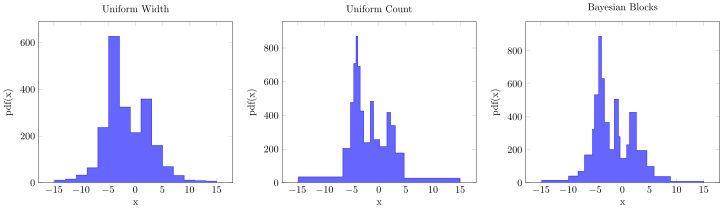

In [12]:
using PGFPlots
using Distributions

# draw a set of variables and
# filter values to a reasonable range
srand(0)
data = [rand(Cauchy(-5, 1.8), 500);
        rand(Cauchy(-4, 0.8), 2000);
        rand(Cauchy(-1, 0.3), 500);
        rand(Cauchy( 2, 0.8), 1000);
        rand(Cauchy( 4, 1.5), 500)]
data = filter!(x->-15.0 <= x <= 15.0, data)

g = GroupPlot(3, 1, groupStyle = "horizontal sep = 1.75cm")

discalgs = [("Uniform Width", DiscretizeUniformWidth(15)),
            ("Uniform Count", DiscretizeUniformCount(15)),
            ("Bayesian Blocks", DiscretizeBayesianBlocks())]

for (name, discalg) in discalgs
    disc = LinearDiscretizer(binedges(discalg, data))
    counts = get_discretization_counts(disc, data)    
    arr_x, arr_y = get_histogram_plot_arrays(disc.binedges, counts ./ binwidths(disc))
    push!(g, Axis(Plots.Linear(arr_x, convert(Vector{Float64}, arr_y), style="const plot, mark=none, fill=blue!60"), ymin=0, xlabel="x", ylabel="pdf(x)", title=name))
end

g

A third algorithm, MODL, was implemented to find optimal bins given both a continuous data set and a labelled discrete data set. 

In [15]:
data = [randn(100); randn(100)+1.0]
labels = [fill(:cat, 100); fill(:dog, 100)]
integer_labels = encode(CategoricalDiscretizer([:cat, :dog]), labels)
edges = binedges(DiscretizeMODL_Optimal(), data, integer_labels)

3-element Array{AbstractFloat,1}:
 -2.5305   
 -0.0318279
  3.45016  

More information on MODL can be found [here](http://nbviewer.ipython.org/github/sisl/Discretizers.jl/blob/master/doc/MODL/DiscretizationMODL.ipynb).